In [1]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [2]:
from fastai.vision.all import *
from fastbook import *

matplotlib.rc('image', cmap='Greys')

In [3]:
path = untar_data(URLs.MNIST_SAMPLE)

In [4]:
URLs.MNIST_SAMPLE

'https://s3.amazonaws.com/fast-ai-sample/mnist_sample.tgz'

In [5]:
Path.BASE_PATH = path
path.ls()

(#3) [Path('train'),Path('valid'),Path('labels.csv')]

In [6]:
(path/'train').ls()

(#2) [Path('train/7'),Path('train/3')]

In [7]:
def get_img_loader(url, train_folder, valid_folder, presize, resize, bs):
  path = untar_data(url)
  dblock = DataBlock(
      blocks = (ImageBlock, CategoryBlock),
      splitter = GrandparentSplitter(train_name=train_folder, valid_name=valid_folder),
      get_items = get_image_files,
      get_y = parent_label,
      item_tfms = Resize(presize),
      batch_tfms = aug_transforms(min_scale=0.5, size=resize)
  )
  dls = dblock.dataloaders(path, bs=bs)
  return dls

In [8]:
dls = get_img_loader(URLs.MNIST_SAMPLE, 'train', 'valid', 28, 28, 64)
x_t, y_t = dls.train.one_batch()

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1051: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:766.)
  ret = func(*args, **kwargs)


In [9]:
x_t.shape, y_t.shape

(torch.Size([64, 3, 28, 28]), torch.Size([64]))

In [10]:
def _single_conv(ch_in, ch_out, ks, stride=1, act=True, gammaZero=False):
        # do not reduce size due to ks mismatch
        padding = ks//2
        layers = [nn.Conv2d(ch_in, ch_out, ks, stride=stride, padding=padding)]
        # add batch norm to prevent activations from getting too high and adding some randomness to training
        bn = nn.BatchNorm2d(ch_out)
        if gammaZero and torch.cuda.is_available():
            bn.weight = nn.Parameter(torch.zeros(bn.weight.shape, device="cuda"))
        elif gammaZero:
            bn.weight = nn.Parameter(torch.zeros(bn.weight.shape, device="cpu"))

        layers.append(bn)
        # check if this layer should have an activation - yes unless the final layer
        if act:
            layers.append(nn.ReLU())
        
        layers = nn.Sequential(*layers)
        return layers

In [11]:
class ResBlock(nn.Module):
    def __init__(self, ch_in, ch_out, stride=1):
        super().__init__()

        self.conv = self._resblock_conv(ch_in, ch_out, stride=stride)
        self.pool = self._return if stride == 1 else nn.AvgPool2d(stride, ceil_mode=True)
        self.id_conv = self._return if ch_in == ch_out else _single_conv(ch_in, ch_out, 1, act=False)
        self.relu = nn.ReLU()

    def _return(self, x):
        return x
    
    def _resblock_conv(self, ch_in, ch_out, stride=1, ks=3):
        conv_block = nn.Sequential(
            _single_conv(ch_in, ch_out//4, 1),
            _single_conv(ch_out//4, ch_out//4, ks, stride=stride), 
            _single_conv(ch_out//4, ch_out, 1, act=False, gammaZero=True)
        )
        return conv_block
    
    def forward(self, x):
        return self.relu(self.conv(x) + self.id_conv(self.pool(x)))

In [12]:
class ResNet(nn.Module):
    def __init__(self, layers, dls_out, expansion=1):
        super().__init__()
        # this contains the number of layers; the length of the array is one less than self.block_ch_sizes below
        self.layers = layers
        self.stem = self._stem([3, 32, 32, 64])
        self.block_ch_sizes = [64, 64, 128, 256, 512]
        # expand the number of channels by a scale factor if desired
        if expansion != 1:
            # do not change the first block to avoid size mismatches
            for i in range(1, len(self.block_ch_sizes)):
                self.block_ch_sizes[i] *= expansion
        self.res_layers = self._create_res_layers()

        self.ad_pool = nn.AdaptiveAvgPool2d(1)
        self.flatten = nn.Flatten()
        self.drop = nn.Dropout(0.4)
        self.fc1 = nn.Linear(self.block_ch_sizes[-1], dls_out*8)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(dls_out*8, dls_out)
        # self.sig = nn.Sigmoid()

    def _stem(self, sizes):
        stem = [
            *[_single_conv(sizes[i], sizes[i+1], 3, stride = 2 if i == 0 else 1)
                for i in range(len(sizes) - 1)
            ],
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        ]
        # print(stem)
        return nn.Sequential(*stem)
    
    def _create_res_layers(self):
        res_layers = []
        # loop through each layer which may be of different sizes (a layer is characterized by having the same number of channels)
        for i, n_layer in enumerate(self.layers):
            # get the input and output channels for the layer
            ch_in, ch_out = self.block_ch_sizes[i: i+2]
            # first layer follow a maxpool so stride 1
            stride = 1 if i == 0 else 2
            res_layers.append(
                nn.Sequential(*[
                    ResBlock(ch_in if j == 0 else ch_out, ch_out, stride = stride if j == 0 else 1)
                    for j in range(n_layer)
                ])
            )
        return nn.Sequential(*res_layers)
    
    def forward(self, x):
        x_stem = self.stem(x)
        # print(x_stem.shape)
        x_res = self.res_layers(x_stem)
        x_pre_dense = self.flatten(self.ad_pool(x_res))
        # print(x_pre_dense.shape)
        x_fc1 = self.relu(self.fc1(self.drop(x_pre_dense)))
        x_out = self.fc2(self.drop(x_fc1))

        return x_out


In [13]:
dls_out = dls.c
rn = ResNet([2, 2, 2, 2], dls_out, expansion=4)

In [21]:
def get_learner(dls, model, loss, cbs=[]):
    learn = Learner(dls, model, loss_func=loss, metrics=accuracy, cbs=cbs)
    return learn


learn_rn = get_learner(dls, rn, CrossEntropyLossFlat())


In [15]:
learn_rn.fit_one_cycle(3, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.140817,0.060080,0.980373,00:44
1,0.082699,0.015169,0.993621,00:45
2,0.034989,0.008005,0.997547,00:45


## Train on the full MNIST dataset 
- First train with just a normal loss function
- Second increase epochs and train mixup
- Finally train label smoothing with mixup

In [18]:
untar_data(URLs.MNIST).ls()

(#2) [Path('/root/.fastai/data/mnist_png/training'),Path('/root/.fastai/data/mnist_png/testing')]

In [16]:
mnist_dls = get_img_loader(URLs.MNIST, 'training', 'testing', 28, 28, 128)
x_t, y_t = mnist_dls.train.one_batch()

In [17]:
x_t.shape, y_t.shape

(torch.Size([128, 3, 28, 28]), torch.Size([128]))

In [18]:
y_t

TensorCategory([1, 3, 0, 8, 8, 9, 5, 9, 4, 3, 6, 3, 5, 5, 8, 5, 3, 1, 7, 2, 7, 5, 5, 8, 6, 7, 8, 8, 7, 3, 8, 4, 2, 1, 5, 8, 9, 4, 8, 9, 5, 8, 9, 7, 8, 5, 2, 7, 2, 5, 1, 4, 3, 9, 9, 5, 8, 3, 6, 4, 2, 2, 8, 5,
        1, 3, 8, 1, 0, 2, 3, 8, 8, 4, 9, 6, 4, 0, 0, 5, 6, 9, 1, 8, 5, 9, 1, 6, 5, 2, 1, 9, 0, 1, 2, 7, 6, 8, 2, 9, 0, 1, 4, 6, 7, 0, 5, 2, 2, 2, 5, 6, 6, 0, 5, 0, 7, 3, 9, 6, 8, 1, 2, 1, 1, 4, 9, 3],
       device='cuda:0')

In [19]:
mnist_dls_out = mnist_dls.c
rn_18 = ResNet([2, 2, 2, 2], mnist_dls_out, expansion=4)
rn_18 = rn_18.cuda()
mnist_learn = get_learner(mnist_dls, rn_18, CrossEntropyLossFlat())

SuggestedLRs(valley=0.0012022644514217973)

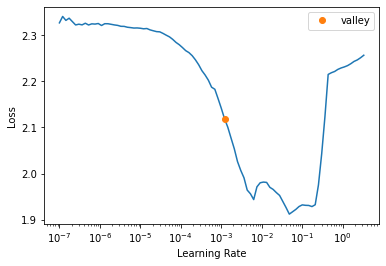

In [20]:
mnist_learn.lr_find()

In [22]:
mnist_learn.fit_one_cycle(5, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.327691,0.725092,0.812700,02:45
1,0.205120,0.183251,0.944800,02:46
2,0.141620,0.119690,0.964600,02:49
3,0.082123,0.051614,0.981900,02:46
4,0.071739,0.045963,0.985800,02:45


## Try training with mixup
- Mixup will combine images so that training images are partially from different classes

In [90]:
class ShowMixUp(Callback):
  def __init__(self, mu, n_inp=5):
    self.mu = mu
    self.n_inp = n_inp
    self.show = True

  def after_pred(self):
    if self.show:
      for i in range(self.n_inp):
        img = self.learn.x[i]
        show_image(img)
        pct_im1 = self.mu.lam[i].item()
        pct_im2 = 1-pct_im1
        print(f"Img{i} epoch {self.learn.n_epoch}: {round(pct_im1, 2)}% number {self.mu.yb[0][i].item()} and {round(pct_im2, 2)}% number {self.mu.yb1[0][i]}")
    self.show = False
  
  def after_epoch(self):
    self.show = True

In [91]:
mnist_dls_out = mnist_dls.c
rn_18 = ResNet([2, 2, 2, 2], mnist_dls_out, expansion=4)
rn_18 = rn_18.cuda()
mu = MixUp()
mnist_learn = get_learner(mnist_dls, rn_18, CrossEntropyLossFlat(), cbs=[mu, ShowMixUp(mu)])

Img0 epoch 1: 0.98% number 1 and 0.02% number 9
Img1 epoch 1: 0.55% number 4 and 0.45% number 3
Img2 epoch 1: 0.85% number 1 and 0.15% number 9
Img3 epoch 1: 0.58% number 6 and 0.42% number 3
Img4 epoch 1: 0.71% number 9 and 0.29% number 6


KeyboardInterrupt: ignored

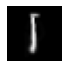

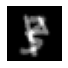

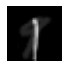

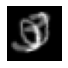

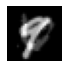

In [92]:
mnist_learn.lr_find()
  

In [94]:
mnist_dls_out = mnist_dls.c
rn_18 = ResNet([2, 2, 2, 2], mnist_dls_out, expansion=4)
rn_18 = rn_18.cuda()
mu = MixUp()
mnist_learn = get_learner(mnist_dls, rn_18, CrossEntropyLossFlat(), cbs=[mu, ShowMixUp(mu)])

Img0 epoch 1: 0.97% number 5 and 0.03% number 7
Img1 epoch 1: 0.98% number 9 and 0.02% number 8
Img2 epoch 1: 0.69% number 1 and 0.31% number 1
Img3 epoch 1: 0.99% number 1 and 0.01% number 6
Img4 epoch 1: 1.0% number 3 and 0.0% number 3


SuggestedLRs(valley=0.0003981071640737355)

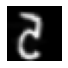

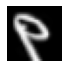

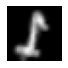

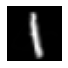

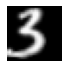

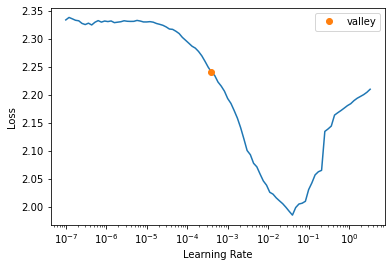

In [95]:
mnist_learn.lr_find()

In [ ]:
mnist_learn.fit_one_cycle(10, 1e-4)